# Pattern Comparison and Story

This notebook creates team profiles and compares strengths vs weaknesses across multiple teams.

We will:
- Load processed data (or recompute from raw)
- Compute zone profiles for multiple teams
- Compare team patterns
- Generate insights and narratives


In [41]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path

# Add project root to path
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import project modules
from src.data_loader import load_raw_events, load_match_info, load_processed
from src.feature_engineering import add_zone_columns
from src.analysis_utils import compute_team_zone_profile, compute_zone_success_rate

# Set plotting style
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Processed Data (or Recompute)


In [42]:
# Load raw data
events = load_raw_events()
match_info = load_match_info()

# Add zones
events = add_zone_columns(events, x_col="start_x", y_col="start_y")

# Create team name mapping (Korean)
team_name_map = {}
for _, row in match_info.iterrows():
    team_name_map[row['home_team_id']] = row['home_team_name_ko']
    team_name_map[row['away_team_id']] = row['away_team_name_ko']

# Create team name mapping (Korean -> English for plots)
team_name_en_map = {
    'FC서울': 'FC Seoul',
    '김천 상무 프로축구단': 'Gimcheon Sangmu FC',
    '울산 HD FC': 'Ulsan HD FC',
    '수원FC': 'Suwon FC',
    '포항 스틸러스': 'Pohang Steelers',
    '전북 현대 모터스': 'Jeonbuk Hyundai Motors',
    '제주SK FC': 'Jeju United FC',
    '강원FC': 'Gangwon FC',
    '대구FC': 'Daegu FC',
    '인천 유나이티드': 'Incheon United',
    '광주FC': 'Gwangju FC',
    '대전 하나 시티즌': 'Daejeon Hana Citizen'
}

# Add team names to events
events['team_name_ko'] = events['team_id'].map(team_name_map)
events['team_name_en'] = events['team_name_ko'].map(team_name_en_map)

print(f"Events loaded: {len(events)}")
print(f"Teams found: {len(team_name_map)}")
print(f"\nTeam names (Korean):")
for team_id, team_name in sorted(team_name_map.items()):
    print(f"  {team_id}: {team_name} ({team_name_en_map.get(team_name, 'N/A')})")


Events loaded: 579306
Teams found: 12

Team names (Korean):
  316: FC서울 (FC Seoul)
  2353: 김천 상무 프로축구단 (Gimcheon Sangmu FC)
  2354: 울산 HD FC (Ulsan HD FC)
  4220: 수원FC (Suwon FC)
  4639: 포항 스틸러스 (Pohang Steelers)
  4640: 전북 현대 모터스 (Jeonbuk Hyundai Motors)
  4641: 제주SK FC (Jeju United FC)
  4643: 강원FC (Gangwon FC)
  4644: 대구FC (Daegu FC)
  4646: 인천 유나이티드 (Incheon United)
  4648: 광주FC (Gwangju FC)
  4657: 대전 하나 시티즌 (Daejeon Hana Citizen)


## Team Profile Table


In [43]:
# Compute zone profiles for multiple teams
team_profiles = compute_team_zone_profile(
    events,
    team_col="team_id",
    event_type_filter=["Pass", "Shot"],
    event_type_col="type_name",
)

# Add team names (Korean for print, English for plots)
team_profiles['team_name'] = team_profiles['team_id'].map(team_name_map)
team_profiles['team_name_en'] = team_profiles['team_name'].map(team_name_en_map)

print("Team Zone Profiles (top zones per team):")
print("=" * 50)

# Show top 3 zones per team
top_zones = team_profiles.groupby("team_id").apply(
    lambda x: x.nlargest(3, "event_count")
).reset_index(drop=True)

print(top_zones[['team_name', 'zone', 'event_count', 'event_count_pct']].head(20))


Team Zone Profiles (top zones per team):
      team_name  zone  event_count  event_count_pct
0          FC서울  DM-R         2374        14.640765
1          FC서울  AM-L         2008        12.383595
2          FC서울  DM-L         1961        12.093740
3   김천 상무 프로축구단  AM-R         2065        13.897301
4   김천 상무 프로축구단  DM-L         1824        12.275389
5   김천 상무 프로축구단  DM-R         1781        11.986002
6      울산 HD FC  DM-R         2354        13.340134
7      울산 HD FC  AM-L         2228        12.626091
8      울산 HD FC  AM-R         2165        12.269069
9          수원FC  DM-R         2121        13.558780
10         수원FC  DM-L         2083        13.315860
11         수원FC  AM-R         2013        12.868376
12      포항 스틸러스  AM-R         2083        12.922638
13      포항 스틸러스  DM-L         2075        12.873007
14      포항 스틸러스  DM-R         1937        12.016874
15    전북 현대 모터스  AM-L         1936        12.908388
16    전북 현대 모터스  AM-R         1912        12.748366
17    전북 현대 모터스  DM-R  

C:\Users\hyoju\AppData\Local\Temp\ipykernel_60180\4137078904.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_zones = team_profiles.groupby("team_id").apply(


## 1. 팀 간 Zone 프로필 비교 히트맵


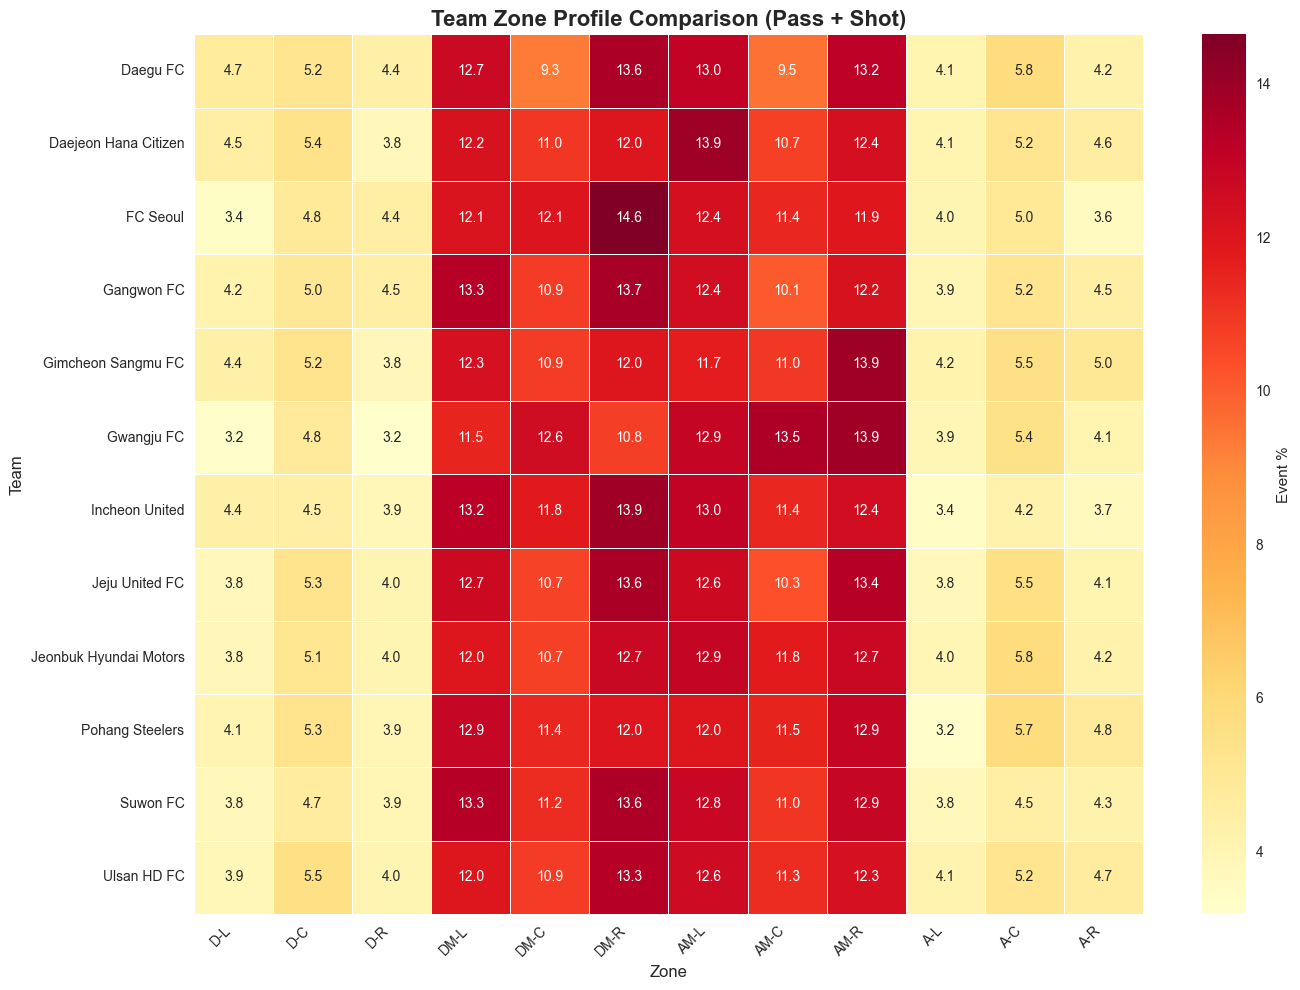

In [44]:
# Create heatmap comparing zone profiles across teams
if len(team_profiles) > 0:
    # Create pivot table: teams x zones (use English names for plot)
    zone_pivot = team_profiles.pivot_table(
        values='event_count_pct',
        index='team_name_en',
        columns='zone',
        fill_value=0
    )
    
    # Sort zones logically
    zone_order = ['D-L', 'D-C', 'D-R', 'DM-L', 'DM-C', 'DM-R', 'AM-L', 'AM-C', 'AM-R', 'A-L', 'A-C', 'A-R']
    existing_zones = [z for z in zone_order if z in zone_pivot.columns]
    if existing_zones:
        zone_pivot = zone_pivot[existing_zones]
    
    # Sort teams alphabetically by English name
    zone_pivot = zone_pivot.sort_index()
    
    # Plot heatmap
    fig, ax = plt.subplots(figsize=(14, 10))
    sns.heatmap(
        zone_pivot,
        annot=True,
        fmt='.1f',
        cmap='YlOrRd',
        ax=ax,
        cbar_kws={'label': 'Event %'},
        linewidths=0.5
    )
    ax.set_title('Team Zone Profile Comparison (Pass + Shot)', fontsize=16, fontweight='bold')
    ax.set_xlabel('Zone', fontsize=12)
    ax.set_ylabel('Team', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print("No team profiles available.")


## 2. 팀별 공격 성공률 비교


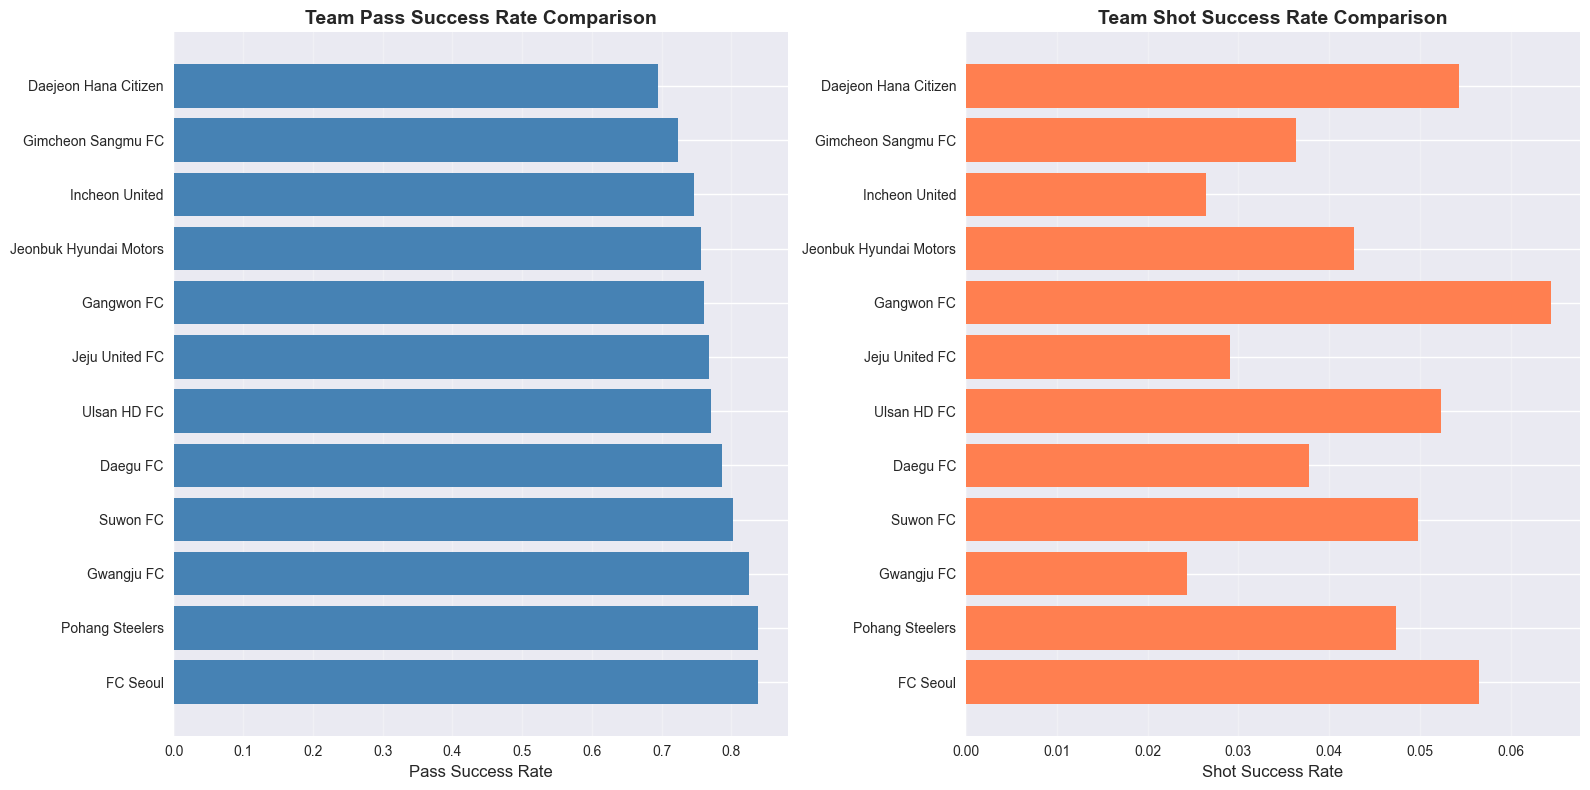


Top 5 Teams by Pass Success Rate:
   team_name  pass_success_rate  total_pass_attempts
5       FC서울           0.838707                15869
1    포항 스틸러스           0.837629                15766
4       광주FC           0.825940                15525
7       수원FC           0.802437                15240
10      대구FC           0.787033                12595


In [45]:
# Compute offense success rates for all teams
from src.feature_engineering import filter_team_vs_opponent

team_offense_success = []

for team_id, team_name in team_name_map.items():
    # Filter for offense perspective
    team_events = filter_team_vs_opponent(
        events,
        team_col="team_id",
        target_team=team_id,
        as_defender=False,
        match_info=match_info,
    )
    
    if len(team_events) > 0:
        # Compute success rate
        success_by_zone = compute_zone_success_rate(
            team_events,
            event_type_col="type_name",
            outcome_col="result_name",
        )
        
        # Filter for Pass and Shot
        key_events = success_by_zone[success_by_zone['event_type'].isin(['Pass', 'Shot'])]
        
        if len(key_events) > 0:
            # Calculate overall success rate
            overall_pass = key_events[key_events['event_type'] == 'Pass']
            overall_shot = key_events[key_events['event_type'] == 'Shot']
            
            pass_success = overall_pass['success_rate'].mean() if len(overall_pass) > 0 else 0
            shot_success = overall_shot['success_rate'].mean() if len(overall_shot) > 0 else 0
            
            team_offense_success.append({
                'team_id': team_id,
                'team_name': team_name,
                'pass_success_rate': pass_success,
                'shot_success_rate': shot_success,
                'total_pass_attempts': overall_pass['attempts'].sum() if len(overall_pass) > 0 else 0,
                'total_shot_attempts': overall_shot['attempts'].sum() if len(overall_shot) > 0 else 0,
            })

offense_df = pd.DataFrame(team_offense_success)

if len(offense_df) > 0:
    # Add English names for plots
    offense_df['team_name_en'] = offense_df['team_name'].map(team_name_en_map)
    
    # Sort by pass success rate
    offense_df = offense_df.sort_values('pass_success_rate', ascending=False)
    
    # Plot comparison (use English names)
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Pass success rate
    axes[0].barh(offense_df['team_name_en'], offense_df['pass_success_rate'], color='steelblue')
    axes[0].set_xlabel('Pass Success Rate', fontsize=12)
    axes[0].set_title('Team Pass Success Rate Comparison', fontsize=14, fontweight='bold')
    axes[0].grid(axis='x', alpha=0.3)
    
    # Shot success rate
    axes[1].barh(offense_df['team_name_en'], offense_df['shot_success_rate'], color='coral')
    axes[1].set_xlabel('Shot Success Rate', fontsize=12)
    axes[1].set_title('Team Shot Success Rate Comparison', fontsize=14, fontweight='bold')
    axes[1].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print with Korean names
    print("\nTop 5 Teams by Pass Success Rate:")
    print(offense_df[['team_name', 'pass_success_rate', 'total_pass_attempts']].head())
else:
    print("No offense data available.")


## 3. 팀별 수비 성공률 비교


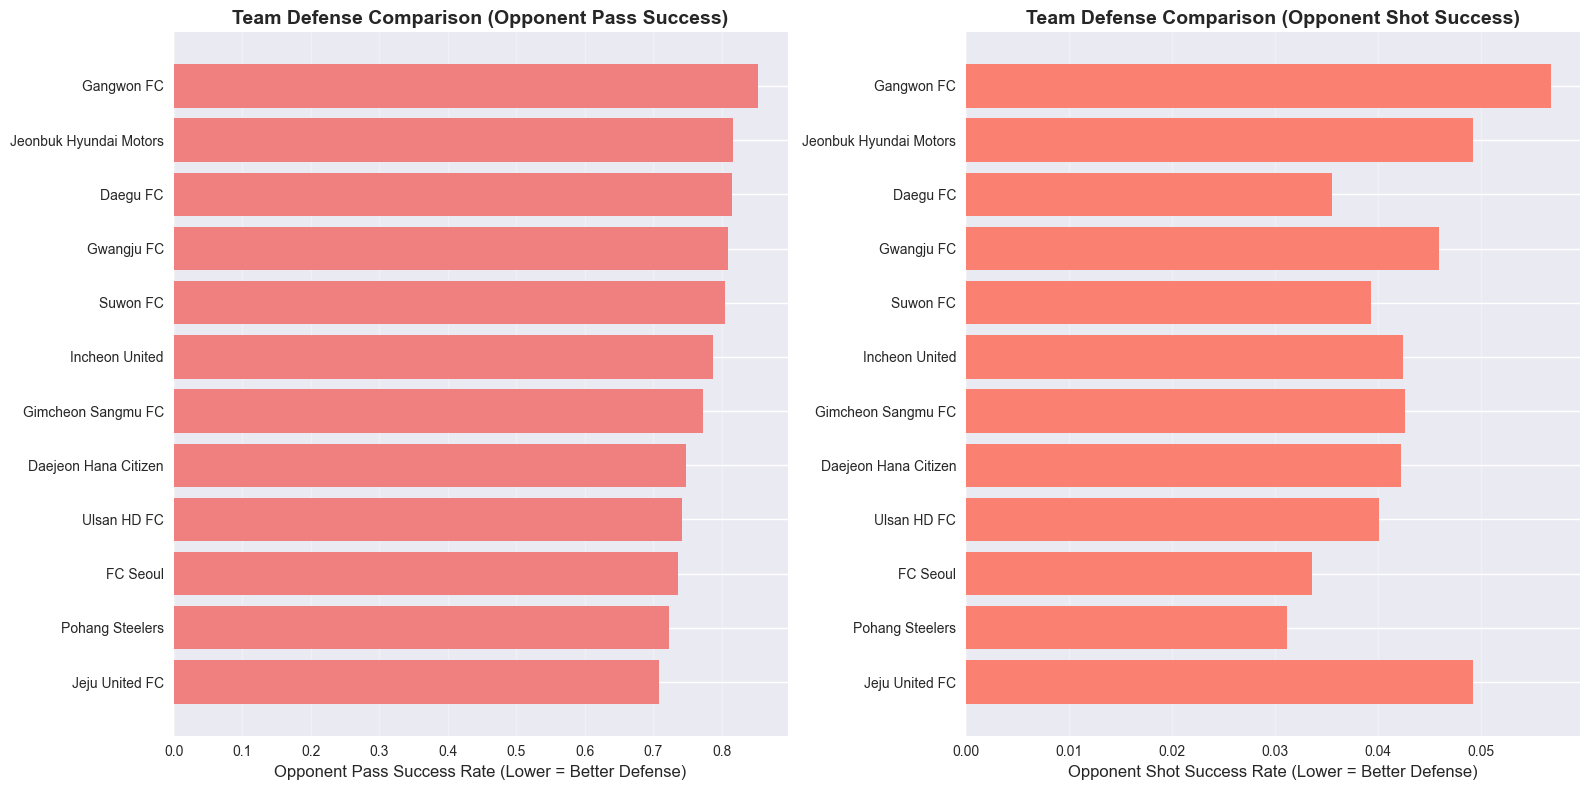


Top 5 Defensive Teams (Lowest Opponent Pass Success Rate):
   team_name  opponent_pass_success_rate  opponent_pass_attempts
9    제주SK FC                    0.708079                   15416
1    포항 스틸러스                    0.723468                   14389
5       FC서울                    0.736739                   13987
0   울산 HD FC                    0.742359                   13525
3  대전 하나 시티즌                    0.747874                   15793


In [46]:
# Compute defense success rates (opponent success rate against each team)
team_defense_success = []

for team_id, team_name in team_name_map.items():
    # Filter for defense perspective (opponent attacks)
    defense_events_team = filter_team_vs_opponent(
        events,
        team_col="team_id",
        target_team=team_id,
        as_defender=True,
        match_info=match_info,
    )
    
    if len(defense_events_team) > 0:
        # Compute opponent success rate (lower is better for defense)
        success_by_zone = compute_zone_success_rate(
            defense_events_team,
            event_type_col="type_name",
            outcome_col="result_name",
        )
        
        # Filter for Pass and Shot
        key_events = success_by_zone[success_by_zone['event_type'].isin(['Pass', 'Shot'])]
        
        if len(key_events) > 0:
            overall_pass = key_events[key_events['event_type'] == 'Pass']
            overall_shot = key_events[key_events['event_type'] == 'Shot']
            
            # Lower opponent success rate = better defense
            opponent_pass_success = overall_pass['success_rate'].mean() if len(overall_pass) > 0 else 0
            opponent_shot_success = overall_shot['success_rate'].mean() if len(overall_shot) > 0 else 0
            
            team_defense_success.append({
                'team_id': team_id,
                'team_name': team_name,
                'opponent_pass_success_rate': opponent_pass_success,
                'opponent_shot_success_rate': opponent_shot_success,
                'opponent_pass_attempts': overall_pass['attempts'].sum() if len(overall_pass) > 0 else 0,
                'opponent_shot_attempts': overall_shot['attempts'].sum() if len(overall_shot) > 0 else 0,
            })

defense_df = pd.DataFrame(team_defense_success)

if len(defense_df) > 0:
    # Add English names for plots
    defense_df['team_name_en'] = defense_df['team_name'].map(team_name_en_map)
    
    # Sort by opponent pass success rate (lower = better defense)
    defense_df = defense_df.sort_values('opponent_pass_success_rate', ascending=True)
    
    # Plot comparison (use English names)
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Opponent pass success rate (lower is better)
    axes[0].barh(defense_df['team_name_en'], defense_df['opponent_pass_success_rate'], color='lightcoral')
    axes[0].set_xlabel('Opponent Pass Success Rate (Lower = Better Defense)', fontsize=12)
    axes[0].set_title('Team Defense Comparison (Opponent Pass Success)', fontsize=14, fontweight='bold')
    axes[0].grid(axis='x', alpha=0.3)
    
    # Opponent shot success rate
    axes[1].barh(defense_df['team_name_en'], defense_df['opponent_shot_success_rate'], color='salmon')
    axes[1].set_xlabel('Opponent Shot Success Rate (Lower = Better Defense)', fontsize=12)
    axes[1].set_title('Team Defense Comparison (Opponent Shot Success)', fontsize=14, fontweight='bold')
    axes[1].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print with Korean names
    print("\nTop 5 Defensive Teams (Lowest Opponent Pass Success Rate):")
    print(defense_df[['team_name', 'opponent_pass_success_rate', 'opponent_pass_attempts']].head())
else:
    print("No defense data available.")


## 4. 팀별 강점/약점 요약 테이블


TEAM STRENGTHS & WEAKNESSES SUMMARY
  team_name  pass_success_rate  shot_success_rate  opponent_pass_success_rate  offense_rank  defense_rank                                   strength     weakness
       FC서울           0.838707           0.056522                    0.736739           1.0           3.0 Strong Offense, Strong Defense, Pass-Heavy         None
    포항 스틸러스           0.837629           0.047396                    0.723468           2.0           2.0 Strong Offense, Strong Defense, Pass-Heavy         None
    제주SK FC           0.768314           0.029045                    0.708079           7.0           1.0                 Strong Defense, Pass-Heavy         None
   울산 HD FC           0.770846           0.052283                    0.742359           6.0           4.0                                 Pass-Heavy         None
       수원FC           0.802437           0.049741                    0.804115           4.0           8.0                                 Pass-Heavy      

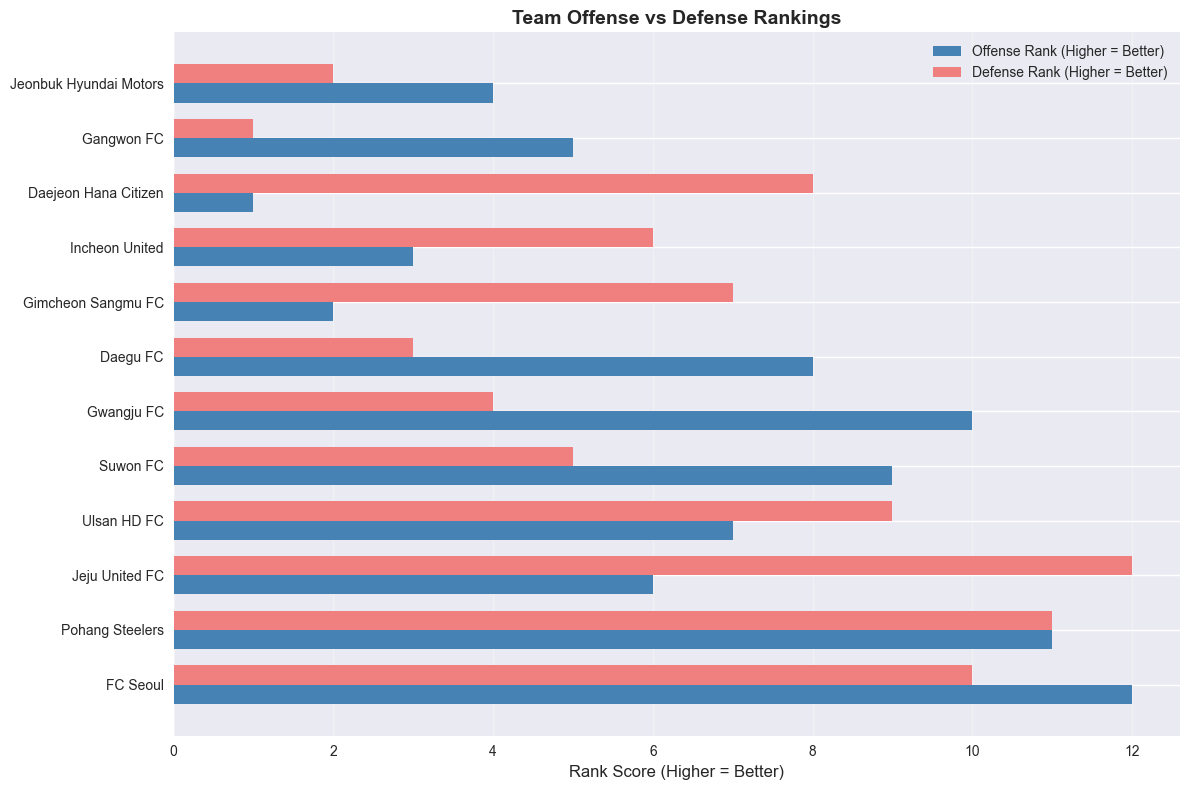

In [47]:
# Create comprehensive team strengths/weaknesses summary
if len(offense_df) > 0 and len(defense_df) > 0:
    # Merge offense and defense data
    team_summary = offense_df.merge(
        defense_df[['team_id', 'opponent_pass_success_rate', 'opponent_shot_success_rate']],
        on='team_id',
        how='outer'
    )
    
    # Calculate rankings
    team_summary['offense_rank'] = team_summary['pass_success_rate'].rank(ascending=False, method='min')
    team_summary['defense_rank'] = team_summary['opponent_pass_success_rate'].rank(ascending=True, method='min')
    team_summary['overall_rank'] = (team_summary['offense_rank'] + team_summary['defense_rank']) / 2
    
    # Identify strengths and weaknesses
    team_summary['strength'] = ''
    team_summary['weakness'] = ''
    
    for idx, row in team_summary.iterrows():
        strengths = []
        weaknesses = []
        
        # Offense strength
        if row['offense_rank'] <= 3:
            strengths.append('Strong Offense')
        elif row['offense_rank'] >= len(team_summary) - 2:
            weaknesses.append('Weak Offense')
        
        # Defense strength
        if row['defense_rank'] <= 3:
            strengths.append('Strong Defense')
        elif row['defense_rank'] >= len(team_summary) - 2:
            weaknesses.append('Weak Defense')
        
        # Pass vs Shot
        if row['pass_success_rate'] > row['shot_success_rate'] * 2:
            strengths.append('Pass-Heavy')
        elif row['shot_success_rate'] > row['pass_success_rate'] * 0.5:
            strengths.append('Shot-Efficient')
        
        team_summary.at[idx, 'strength'] = ', '.join(strengths) if strengths else 'Balanced'
        team_summary.at[idx, 'weakness'] = ', '.join(weaknesses) if weaknesses else 'None'
    
    # Sort by overall rank
    team_summary = team_summary.sort_values('overall_rank')
    
    # Display summary table
    print("=" * 100)
    print("TEAM STRENGTHS & WEAKNESSES SUMMARY")
    print("=" * 100)
    
    display_cols = ['team_name', 'pass_success_rate', 'shot_success_rate', 
                    'opponent_pass_success_rate', 'offense_rank', 'defense_rank', 
                    'strength', 'weakness']
    
    print(team_summary[display_cols].to_string(index=False))
    
    # Add English names for plot
    team_summary['team_name_en'] = team_summary['team_name'].map(team_name_en_map)
    
    # Visualize rankings (use English names)
    fig, ax = plt.subplots(figsize=(12, 8))
    x_pos = np.arange(len(team_summary))
    width = 0.35
    
    # Normalize ranks for visualization (lower rank = better)
    offense_score = len(team_summary) - team_summary['offense_rank'] + 1
    defense_score = len(team_summary) - team_summary['defense_rank'] + 1
    
    ax.barh(x_pos - width/2, offense_score, width, label='Offense Rank (Higher = Better)', color='steelblue')
    ax.barh(x_pos + width/2, defense_score, width, label='Defense Rank (Higher = Better)', color='lightcoral')
    
    ax.set_yticks(x_pos)
    ax.set_yticklabels(team_summary['team_name_en'])
    ax.set_xlabel('Rank Score (Higher = Better)', fontsize=12)
    ax.set_title('Team Offense vs Defense Rankings', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
else:
    print("Insufficient data for summary table.")


## 5. 레이더 차트 (선택 팀 비교)


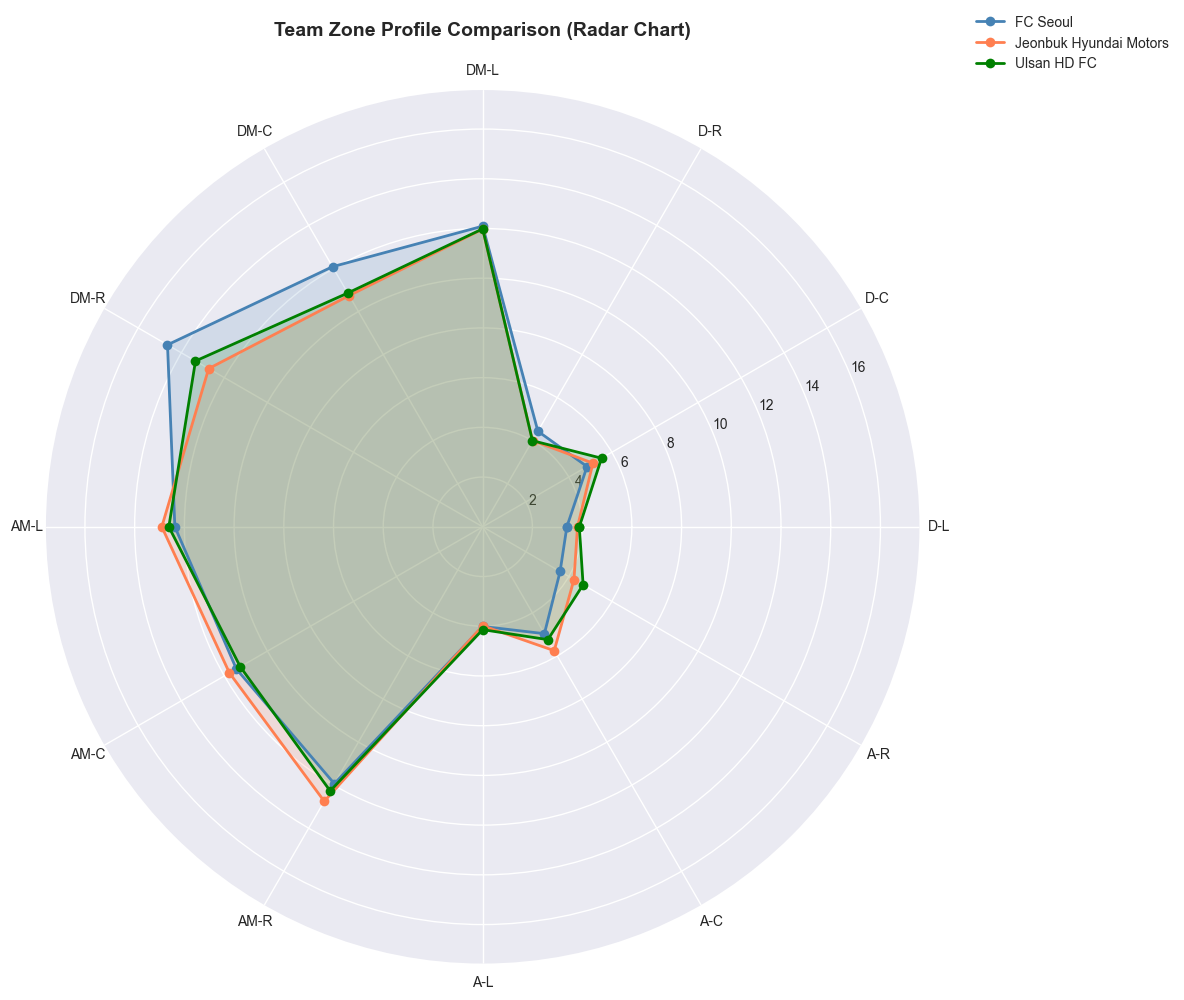


Compared teams: 울산 HD FC, 전북 현대 모터스, FC서울


In [48]:
# Select teams to compare (you can modify this list)
SELECTED_TEAMS = ["울산 HD FC", "전북 현대 모터스", "FC서울"]  # Modify as needed

# Create radar chart for zone profiles
if len(team_profiles) > 0:
    from math import pi
    
    # Get zone order
    zone_order = ['D-L', 'D-C', 'D-R', 'DM-L', 'DM-C', 'DM-R', 'AM-L', 'AM-C', 'AM-R', 'A-L', 'A-C', 'A-R']
    
    # Filter for selected teams
    selected_team_ids = [tid for tid, name in team_name_map.items() if name in SELECTED_TEAMS]
    selected_profiles = team_profiles[team_profiles['team_id'].isin(selected_team_ids)].copy()
    
    if len(selected_profiles) > 0:
        # Create pivot table (use English names for plot)
        radar_data = selected_profiles.pivot_table(
            values='event_count_pct',
            index='team_name_en',
            columns='zone',
            fill_value=0
        )
        
        # Ensure all zones are present
        for zone in zone_order:
            if zone not in radar_data.columns:
                radar_data[zone] = 0
        
        radar_data = radar_data[zone_order]
        
        # Number of variables
        categories = list(radar_data.columns)
        N = len(categories)
        
        # Compute angle for each category
        angles = [n / float(N) * 2 * pi for n in range(N)]
        angles += angles[:1]  # Complete the circle
        
        # Create radar chart
        fig, ax = plt.subplots(figsize=(12, 10), subplot_kw=dict(projection='polar'))
        
        # Plot each team (use English names)
        colors = ['steelblue', 'coral', 'green', 'purple', 'orange']
        for idx, (team_name_en, row) in enumerate(radar_data.iterrows()):
            values = row.values.tolist()
            values += values[:1]  # Complete the circle
            
            ax.plot(angles, values, 'o-', linewidth=2, label=team_name_en, color=colors[idx % len(colors)])
            ax.fill(angles, values, alpha=0.15, color=colors[idx % len(colors)])
        
        # Add category labels
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories, fontsize=10)
        ax.set_ylim(0, radar_data.values.max() * 1.2)
        ax.set_title('Team Zone Profile Comparison (Radar Chart)', fontsize=14, fontweight='bold', pad=20)
        ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
        ax.grid(True)
        
        plt.tight_layout()
        plt.show()
        
        # Print with Korean names
        print(f"\nCompared teams: {', '.join(SELECTED_TEAMS)}")
    else:
        print(f"No data found for selected teams: {SELECTED_TEAMS}")
else:
    print("No team profiles available.")


## 6. 자동화된 인사이트 텍스트 생성


In [49]:
# Generate automated insights for each team
if len(team_summary) > 0 and len(team_profiles) > 0:
    print("=" * 100)
    print("AUTOMATED TEAM INSIGHTS")
    print("=" * 100)
    print()
    
    for _, team_row in team_summary.iterrows():
        team_name = team_row['team_name']
        team_id = team_row['team_id']
        
        # Get zone profile for this team
        team_zone_profile = team_profiles[team_profiles['team_id'] == team_id].copy()
        
        if len(team_zone_profile) > 0:
            # Find top zones
            top_zones = team_zone_profile.nlargest(3, 'event_count_pct')
            top_zone_names = top_zones['zone'].tolist()
            top_zone_pcts = top_zones['event_count_pct'].tolist()
            
            # Find bottom zones
            bottom_zones = team_zone_profile.nsmallest(3, 'event_count_pct')
            bottom_zone_names = bottom_zones['zone'].tolist()
            
            # Generate insights
            insights = []
            
            # Offense insights
            if team_row['offense_rank'] <= 3:
                insights.append(f"강력한 공격력을 보유하고 있습니다 (공격 순위: {int(team_row['offense_rank'])}위).")
            elif team_row['offense_rank'] >= len(team_summary) - 2:
                insights.append(f"공격력 개선이 필요합니다 (공격 순위: {int(team_row['offense_rank'])}위).")
            
            # Defense insights
            if team_row['defense_rank'] <= 3:
                insights.append(f"견고한 수비를 보여줍니다 (수비 순위: {int(team_row['defense_rank'])}위).")
            elif team_row['defense_rank'] >= len(team_summary) - 2:
                insights.append(f"수비 강화가 필요합니다 (수비 순위: {int(team_row['defense_rank'])}위).")
            
            # Zone insights
            if 'AM-C' in top_zone_names or 'AM-L' in top_zone_names or 'AM-R' in top_zone_names:
                insights.append("공격 중앙/측면 지역에서 많은 활동을 보입니다.")
            if 'DM-C' in top_zone_names or 'DM-L' in top_zone_names or 'DM-R' in top_zone_names:
                insights.append("수비 중앙/측면 지역에서 빌드업을 주로 진행합니다.")
            if 'A-C' in top_zone_names or 'A-L' in top_zone_names or 'A-R' in top_zone_names:
                insights.append("최종 공격 지역에서 활발한 활동을 보입니다.")
            
            # Pass vs Shot insights
            if team_row['pass_success_rate'] > 0.85:
                insights.append(f"높은 패스 성공률을 기록했습니다 ({team_row['pass_success_rate']:.1%}).")
            if team_row['shot_success_rate'] > 0.10:
                insights.append(f"슛 효율성이 높습니다 ({team_row['shot_success_rate']:.1%}).")
            
            # Opponent insights
            if team_row['opponent_pass_success_rate'] < 0.80:
                insights.append(f"상대팀의 패스를 효과적으로 차단합니다 (상대 패스 성공률: {team_row['opponent_pass_success_rate']:.1%}).")
            
            # Print insights
            print(f"📊 {team_name}")
            print("-" * 80)
            print(f"공격 순위: {int(team_row['offense_rank'])}위 | 수비 순위: {int(team_row['defense_rank'])}위")
            print(f"패스 성공률: {team_row['pass_success_rate']:.1%} | 슛 성공률: {team_row['shot_success_rate']:.1%}")
            print(f"상대 패스 성공률: {team_row['opponent_pass_success_rate']:.1%} | 상대 슛 성공률: {team_row['opponent_shot_success_rate']:.1%}")
            print()
            print("주요 활동 Zone:")
            for zone, pct in zip(top_zone_names, top_zone_pcts):
                print(f"  - {zone}: {pct:.1f}%")
            print()
            print("인사이트:")
            for insight in insights:
                print(f"  • {insight}")
            print()
            print("=" * 100)
            print()
    
    # Overall league insights
    print("\n" + "=" * 100)
    print("리그 전체 인사이트")
    print("=" * 100)
    print()
    
    avg_pass_success = offense_df['pass_success_rate'].mean()
    avg_shot_success = offense_df['shot_success_rate'].mean()
    avg_defense = defense_df['opponent_pass_success_rate'].mean()
    
    print(f"• 리그 평균 패스 성공률: {avg_pass_success:.1%}")
    print(f"• 리그 평균 슛 성공률: {avg_shot_success:.1%}")
    print(f"• 리그 평균 상대 패스 성공률: {avg_defense:.1%}")
    print()
    
    best_offense = team_summary.loc[team_summary['offense_rank'].idxmin()]
    best_defense = team_summary.loc[team_summary['defense_rank'].idxmin()]
    
    print(f"• 최고 공격 팀: {best_offense['team_name']} (패스 성공률: {best_offense['pass_success_rate']:.1%})")
    print(f"• 최고 수비 팀: {best_defense['team_name']} (상대 패스 성공률: {best_defense['opponent_pass_success_rate']:.1%})")
    print()
    
else:
    print("Insufficient data for insights generation.")


AUTOMATED TEAM INSIGHTS

📊 FC서울
--------------------------------------------------------------------------------
공격 순위: 1위 | 수비 순위: 3위
패스 성공률: 83.9% | 슛 성공률: 5.7%
상대 패스 성공률: 73.7% | 상대 슛 성공률: 3.4%

주요 활동 Zone:
  - DM-R: 14.6%
  - AM-L: 12.4%
  - DM-L: 12.1%

인사이트:
  • 강력한 공격력을 보유하고 있습니다 (공격 순위: 1위).
  • 견고한 수비를 보여줍니다 (수비 순위: 3위).
  • 공격 중앙/측면 지역에서 많은 활동을 보입니다.
  • 수비 중앙/측면 지역에서 빌드업을 주로 진행합니다.
  • 상대팀의 패스를 효과적으로 차단합니다 (상대 패스 성공률: 73.7%).


📊 포항 스틸러스
--------------------------------------------------------------------------------
공격 순위: 2위 | 수비 순위: 2위
패스 성공률: 83.8% | 슛 성공률: 4.7%
상대 패스 성공률: 72.3% | 상대 슛 성공률: 3.1%

주요 활동 Zone:
  - AM-R: 12.9%
  - DM-L: 12.9%
  - DM-R: 12.0%

인사이트:
  • 강력한 공격력을 보유하고 있습니다 (공격 순위: 2위).
  • 견고한 수비를 보여줍니다 (수비 순위: 2위).
  • 공격 중앙/측면 지역에서 많은 활동을 보입니다.
  • 수비 중앙/측면 지역에서 빌드업을 주로 진행합니다.
  • 상대팀의 패스를 효과적으로 차단합니다 (상대 패스 성공률: 72.3%).


📊 제주SK FC
--------------------------------------------------------------------------------
공격 순위: 7위 | 수비 순위: 1위
패스 성공률: 76.8% | 슛 성공률: 